## Relatórios
Agora, chegamos no momento em que a qualidade foi aferida e as transformações necessárias para que os
dados sejam úteis, já foram realizadas. Este momento conseguimos responder perguntas importantes para
direcionar esforços para melhorar a qualidade dos dados e também responder perguntas de negócio que
são essenciais para tomada de decisão.

In [2]:
# Locate spark
import findspark
findspark.init()

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# Importando pacotes
import re
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F  # Importando todas as funções 
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

In [5]:
# Expressoes regulares comuns
# Boas práticas (variáveis constantes em maiusculo)
REGEX_ALPHA    = r'[a-zA-Z]+'
REGEX_INTEGER  = r'[0-9]+'
REGEX_FLOAT    = r'[0-9]+\.[0-9]+'
REGEX_ALPHANUM = r'[0-9a-zA-Z]+'
REGEX_EMPTY_STR= r'[\t ]+$'
REGEX_SPECIAL  = r'[!@#$%&*\(\)_]+'
REGEX_NNUMBER  = r'^N[1-9][0-9]{2,3}([ABCDEFGHJKLMNPRSTUVXWYZ]{1,2})'
REGEX_NNUMBER_INVALID = r'(N0.*$)|(.*[IO].*)'
REGEX_TIME_FMT = r'^(([0-1]?[0-9])|(2[0-3]))([0-5][0-9])$'

In [6]:
# Funcoes auxiliares 
def split_csv(line):
    return tuple(map(lambda x: x.replace('"',''), line.split(",")))

def check_empty_column(col):
    return (F.col(col).isNull() | (F.col(col) =='') | F.col(col).rlike(REGEX_EMPTY_STR))

In [7]:
# Criar o contexto do spark
sc = SparkContext()

# Instancia o criador de sessao do spark
spark = (SparkSession.builder
                     .master("local[7]")
                     .appName("Aceleração PySpark - Capgemini"))

In [8]:
# Lendo arquivo parquet

flights_proc = (spark.getOrCreate().read
                   .format("parquet")
                   .option("header","True")
                   .load("Datasets/transformacao/flights_proc.parquet"))


# Lendo arquivo parquet
planes_proc = (spark.getOrCreate().read
                   .format("parquet")
                   .option("header","True")
                   .load("Datasets/transformacao/planes_proc.parquet"))


# Lendo arquivo parquet
airports_proc = (spark.getOrCreate().read
                   .format("parquet")
                   .option("header","True")
                   .load("Datasets/transformacao/airports_proc.parquet"))


In [9]:
# Criacao das visões temporarias
flights_proc.createOrReplaceTempView('flights')
planes_proc.createOrReplaceTempView('planes')
airports_proc.createOrReplaceTempView('airports')

### 1. Crie uma base de dados unificando os datasets transformados<br> ( airports_proc.parquet ,planes_proc.parquet , flights_proc.parquet )<br> considerando as seguintes chaves em comum:
**faa - flights.origin** <br>
**airports.faa - flights.dest** <br>
**planes.tailnum - flights.tailnum**<br>

In [10]:
# Renomeando colunas
# Renomeando colunas
flights_proc = flights_proc.select(*(F.col(x).alias('fl_' + x ) for x in flights_proc.columns))
planes_proc = planes_proc.select(*(F.col(x).alias('pl_' + x ) for x in planes_proc.columns))
airports_proc2 = airports_proc.select(*(F.col(x).alias('air2_' + x ) for x in airports_proc.columns))
airports_proc = airports_proc.select(*(F.col(x).alias('air_' + x ) for x in airports_proc.columns))

In [11]:
# Verificando schemas 
flights_proc.printSchema()
planes_proc.printSchema()
airports_proc.printSchema()

root
 |-- fl_dep_time: string (nullable = true)
 |-- fl_dep_delay: integer (nullable = true)
 |-- fl_arr_time: string (nullable = true)
 |-- fl_arr_delay: integer (nullable = true)
 |-- fl_carrier: string (nullable = true)
 |-- fl_tailnum: string (nullable = true)
 |-- fl_flight: string (nullable = true)
 |-- fl_origin: string (nullable = true)
 |-- fl_dest: string (nullable = true)
 |-- fl_air_time: double (nullable = true)
 |-- fl_distance: integer (nullable = true)
 |-- fl_dep_datetime: timestamp (nullable = true)
 |-- fl_air_time_projected: integer (nullable = true)
 |-- fl_air_time_expected: integer (nullable = true)
 |-- fl_haul_duration: string (nullable = true)
 |-- fl_dep_season: string (nullable = true)
 |-- fl_dep_delay_category: string (nullable = true)

root
 |-- pl_tailnum: string (nullable = true)
 |-- pl_year: string (nullable = true)
 |-- pl_type: string (nullable = true)
 |-- pl_manufacturer: string (nullable = true)
 |-- pl_model: string (nullable = true)
 |-- pl_eng

In [12]:
## Contando a quantidade linhas do dataset flights 
flights_proc.count()


10000

In [13]:
## corrigido
df_final = flights_proc.join(airports_proc, (flights_proc.fl_origin == airports_proc.air_faa) ,'left')\
                       .join(airports_proc2,(flights_proc.fl_dest  == airports_proc2.air2_faa),'left')\
                       .join(planes_proc,   (flights_proc.fl_tailnum == planes_proc.pl_tailnum),'left')

In [14]:
df_1 = airports_proc
df_2 = airports_proc

### 2. Quantos aeroportos existem em cada region ?


In [15]:
df_final.show(1,vertical=True)

-RECORD 0------------------------------------
 fl_dep_time           | 658                 
 fl_dep_delay          | -7                  
 fl_arr_time           | 935                 
 fl_arr_delay          | -5                  
 fl_carrier            | VX                  
 fl_tailnum            | N846VA              
 fl_flight             | 1780                
 fl_origin             | SEA                 
 fl_dest               | LAX                 
 fl_air_time           | 132.0               
 fl_distance           | 954                 
 fl_dep_datetime       | 2014-12-08 06:58:00 
 fl_air_time_projected | 115                 
 fl_air_time_expected  | 127                 
 fl_haul_duration      | SHORT-HAUL          
 fl_dep_season         | FALL                
 fl_dep_delay_category | ANTECIPATED         
 air_faa               | SEA                 
 air_name              | Seattle Tacoma Intl 
 air_lat               | 47.449              
 air_lon               | -122.3093

+-------------+-----+
|  air2_region|count|
+-------------+-----+
|       ALASKA|    9|
|MAINLAND-EAST|   24|
|MAINLAND-WEST|   36|
+-------------+-----+



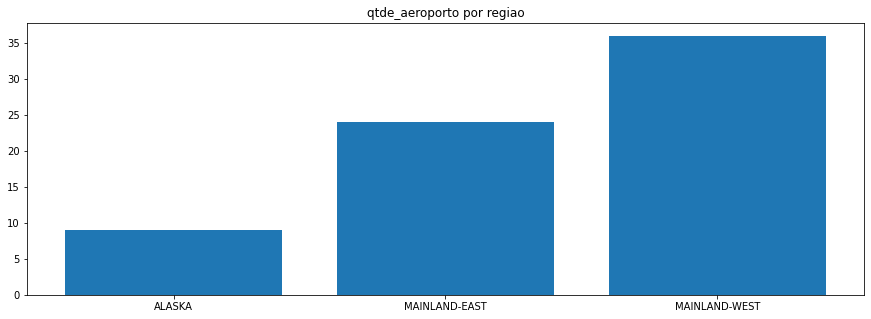

In [16]:
df_final.groupBy(F.col('air2_region')).agg(F.countDistinct('air2_faa').alias('count')).show()

### plot
df_plot = df_final.groupBy(F.col('air2_region')).agg(F.countDistinct('air2_faa').alias('count'))
x = df_plot.toPandas()['air2_region'].values.tolist()
y = df_plot.toPandas()['count'].values.tolist()

plt.figure(figsize=(15,5))
plt.bar(x,y)
plt.title('qtde_aeroporto por regiao')
plt.show()

### 3. Qual é a maior diferença de altitude dos voos? Considere: max(alt_origin - alt_dest)

In [19]:
df_final.agg(F.max(F.col('air_alt') - F.col('air2_alt')).alias('max-somando')).toPandas()

,max-somando
0,429


### 4. Qual é o atraso médio?

In [21]:
df_final.agg(F.mean(F.col('fl_dep_delay') + F.col('fl_arr_delay')).alias('soma_atraso')).toPandas()

,soma_atraso
0,8.2757


In [20]:
### 
(df_final.where((F.col("fl_dep_delay") > 0) | (F.col("fl_arr_delay") > 0))
.agg(F.ceil(F.avg(F.col('fl_dep_delay') + F.col('fl_arr_delay'))).alias("media")).toPandas()

)

,media
0,35


### 5. Qual é o atraso médio para cada região?

+-------------+-----------+
|  air2_region|soma_atraso|
+-------------+-----------+
|       ALASKA|       4.38|
|MAINLAND-EAST|      10.08|
|MAINLAND-WEST|       8.29|
+-------------+-----------+



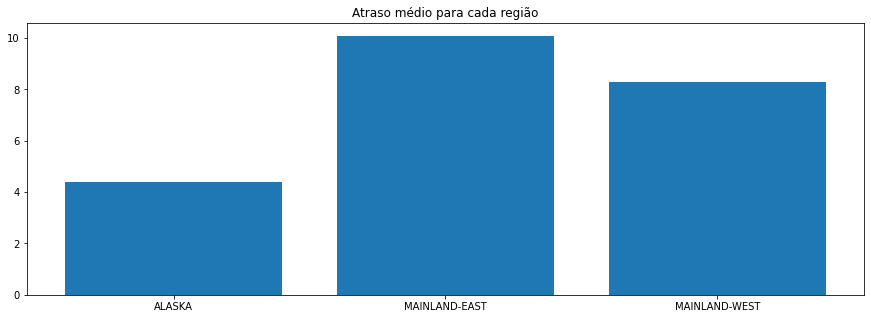

In [22]:
df_final.groupBy('air2_region').agg(F.round(F.avg(F.col('fl_dep_delay') + F.col('fl_arr_delay')),2).alias('soma_atraso')).show()


## plot
df_plot1 = (df_final.groupBy('air2_region')
                    .agg(F.round(F.avg(F.col('fl_dep_delay') + F.col('fl_arr_delay')),2)
                    .alias('soma_atraso')))

x = df_plot1.toPandas()['air2_region'].values.tolist()
y = df_plot1.toPandas()['soma_atraso'].values.tolist()


plt.figure(figsize=(15,5))
plt.bar(x,y)
plt.title('Atraso médio para cada região')
plt.show()


### 6. Qual é o atraso acumulado por ano?

In [23]:
df_final.agg(F.sum(F.col('fl_dep_delay') + F.col('fl_arr_delay')).alias('soma_atraso')).toPandas()

,soma_atraso
0,82757


In [24]:
(df_final.select(F.year("fl_dep_datetime").alias('ano'),"fl_dep_delay",'fl_arr_delay')
.groupBy("ano")
.agg(F.sum('fl_dep_delay').alias('acumulado_ano'))
.toPandas()
)

,ano,acumulado_ano
0,2014,60395


In [ ]:
F.mean(F.col('fl_dep_delay') + F.col('fl_arr_delay')

In [25]:
(df_final.select(F.year("fl_dep_datetime").alias('ano'),"fl_dep_delay",'fl_arr_delay')
.groupBy("ano")
.agg(F.sum(F.col('fl_dep_delay') + F.col('fl_arr_delay')).alias('acumulado_ano_soma'))
.toPandas()
)

,ano,acumulado_ano_soma
0,2014,82757


### 7. Qual é o atraso acumulado por ano para cada região?

In [26]:
(df_final.select(F.year("fl_dep_datetime").alias('ano'),"fl_dep_delay",'fl_arr_delay','air2_region')
.groupBy("ano",'air2_region')
.agg(F.sum(F.col('fl_dep_delay') + F.col('fl_arr_delay')).alias('atraso_acumulado_ano_somando'))
.toPandas()
)

,ano,air2_region,atraso_acumulado_ano_somando
0,2014,ALASKA,4435
1,2014,MAINLAND-EAST,21618
2,2014,MAINLAND-WEST,56704


In [27]:
(df_final.select(F.year("fl_dep_datetime").alias('ano'),"fl_dep_delay",'air2_region')
.groupBy("ano",'air2_region')
.agg(F.sum(F.col('fl_dep_delay')).alias('atraso_acumulado_ano_sem_somar'))
.toPandas()
)

,ano,air2_region,atraso_acumulado_ano_sem_somar
0,2014,ALASKA,4891
1,2014,MAINLAND-EAST,16679
2,2014,MAINLAND-WEST,38825


### 8. Qual é o tempo de voo médio?

In [ ]:
df_final.agg(F.round(F.mean(F.col('fl_air_time')),2).alias('VOO_MEDIO')).toPandas()

In [28]:
(df_final.select(F.col("fl_air_time"))
.agg(F.round(F.mean(F.col('fl_air_time')),2).alias('voo_medio'))
.toPandas()
)

,voo_medio
0,152.87


### 9. Qual é o tempo de voo médio para cada região?

In [29]:
(df_final.select(F.col("fl_air_time"),F.col("air2_region")) ## air2_region -- destino
.groupBy("air2_region")
.agg(F.round(F.mean(F.col('fl_air_time')),2).alias('voo_medio'))
.orderBy('voo_medio')
.toPandas()
)



,air2_region,voo_medio
0,MAINLAND-WEST,115.39
1,ALASKA,227.87
2,MAINLAND-EAST,237.10


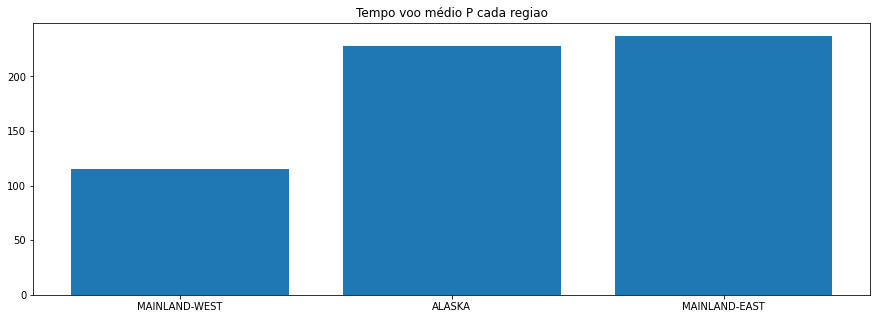

In [30]:
### definindo variavel  
df_plot2 = (df_final.select(F.col("fl_air_time"),F.col("air2_region"))
                .groupBy("air2_region")
                .agg(F.round(F.mean(F.col('fl_air_time')),2).alias('voo_medio'))
                .orderBy('voo_medio')
           )

### plotando 
x = df_plot2.toPandas()['air2_region'].values.tolist()
y = df_plot2.toPandas()['voo_medio'].values.tolist()


plt.figure(figsize=(15,5))
plt.bar(x,y)
plt.title('Tempo voo médio P cada regiao')
plt.show()


### 10. Qual é o tempo de voo médio para cada rota (origem e destino)?

In [31]:
(
df_final.select(F.col('fl_origin'),F.col('fl_dest'),F.col('fl_air_time'))
        .groupBy('fl_origin','fl_dest')
        .agg(F.round(F.mean(F.col('fl_air_time')),2).alias('voo_medio'))
        .toPandas()

)

,fl_origin,fl_dest,voo_medio
0,SEA,RNO,74.38
1,SEA,DTW,219.82
2,SEA,CLE,233.50
3,SEA,LAX,126.86
4,PDX,SEA,34.93
...,...,...,...
108,SEA,JFK,281.54
109,SEA,FAI,198.13
110,PDX,HOU,226.33
111,PDX,BUR,108.51


### 11. Qual é o tempo de voo acumulado por ano?

In [33]:
(df_final.select(F.year("fl_dep_datetime").alias('ano'),"fl_air_time")
.groupBy("ano")
.agg(F.sum('fl_air_time').alias('Acumulado_ano_min'))
.toPandas()
)

,ano,Acumulado_ano_min
0,2014,1528665.0


### 12. Qual é o tempo de voo acumulado para cada região?

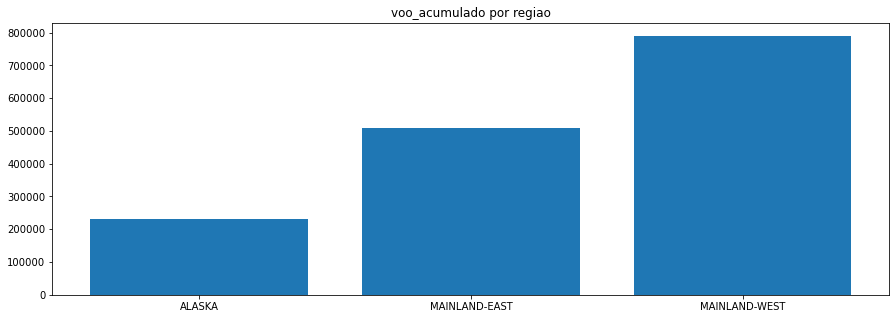

,air2_region,voo_acumulado
0,ALASKA,230607.0
1,MAINLAND-EAST,508353.0
2,MAINLAND-WEST,789705.0


In [34]:
### definindo variavel  
df_plot3 = (df_final.select(F.col("fl_air_time"),F.col("air2_region"))
.groupBy("air2_region")
.agg(F.round(F.sum(F.col('fl_air_time')),2).alias('voo_acumulado'))
.orderBy('voo_acumulado')
)


### plotando 
x = df_plot3.toPandas()['air2_region'].values.tolist()
y = df_plot3.toPandas()['voo_acumulado'].values.tolist()


plt.figure(figsize=(15,5))
plt.bar(x,y)
plt.title('voo_acumulado por regiao')
plt.show()


### resultado em forma de tabela
(df_final.select(F.col("fl_air_time"),F.col("air2_region"))
.groupBy("air2_region")
.agg(F.round(F.sum(F.col('fl_air_time')),2).alias('voo_acumulado'))
.orderBy('voo_acumulado')
.toPandas()
)


### 13. Qual é a distância de voo médio?

In [36]:
(df_final.select(F.col("fl_distance"))
.agg(F.round(F.mean(F.col('fl_distance')),2).alias('distancia_media'))
.toPandas()
)

,distancia_media
0,1208.15


### 14. Qual é a distância de voo médio para cada região?

In [37]:
(df_final.select(F.col("fl_distance"),F.col("air2_region"))
.groupBy("air2_region")
.agg(F.round(F.mean(F.col('fl_distance')),2).alias('distancia_media_regiao'))
.orderBy('distancia_media_regiao')
.toPandas()
)

,air2_region,distancia_media_regiao
0,MAINLAND-WEST,867.92
1,ALASKA,1741.65
2,MAINLAND-EAST,2042.40


### 15. Qual é a distância de voo médio para cada rota (origem e destino)?

In [38]:
(
df_final.select(F.col('fl_origin'),F.col('fl_dest'),F.col('fl_distance'))
        .groupBy('fl_origin','fl_dest')
        .agg(F.round(F.mean(F.col('fl_distance'))).alias('distancia_media'))
        .toPandas()

)

,fl_origin,fl_dest,distancia_media
0,SEA,RNO,564.0
1,SEA,DTW,1927.0
2,SEA,CLE,2021.0
3,SEA,LAX,954.0
4,PDX,SEA,129.0
...,...,...,...
108,SEA,JFK,2422.0
109,SEA,FAI,1533.0
110,PDX,HOU,1843.0
111,PDX,BUR,817.0


### 16. Qual é a distância de voo acumulada por ano?

In [39]:
(df_final.select(F.year("fl_dep_datetime").alias('ano'),"fl_distance")
.groupBy("ano")
.agg(F.sum('fl_distance').alias('Acumulado_ano_min'))
.toPandas()
)

,ano,Acumulado_ano_min
0,2014,12081516


### 17. Qual é a distância de voo acumulada para cada região?

In [40]:
(df_final.select(F.col("fl_distance"),F.col("air2_region"))
.groupBy("air2_region")
.agg(F.round(F.sum(F.col('fl_distance')),2).alias('distancia_acumulada_regiao'))
.orderBy('distancia_acumulada_regiao')
.toPandas()
)

,air2_region,distancia_acumulada_regiao
0,ALASKA,1762553
1,MAINLAND-EAST,4378902
2,MAINLAND-WEST,5940061


### 18. Qual é o número de passageiros médio por rota (origem e destino)?

In [41]:
(
df_final.select(F.col('fl_origin'),F.col('fl_dest'),F.col('pl_seats'))
        .where(F.col('pl_seats') >  0)
        .groupBy('fl_origin','fl_dest')
        .agg(F.round(F.mean(F.col('pl_seats')),2).alias('distancia_media'))
        .toPandas()

)

,fl_origin,fl_dest,distancia_media
0,SEA,RNO,141.13
1,SEA,DTW,212.43
2,SEA,CLE,182.00
3,SEA,LAX,154.71
4,PDX,SEA,64.28
...,...,...,...
108,SEA,JFK,182.60
109,SEA,FAI,179.90
110,PDX,HOU,141.50
111,PDX,BUR,79.65


### 19. Qual é o número de passageiros acumulado por ano?

In [43]:
(df_final.select(F.year("fl_dep_datetime").alias('ano'),"pl_seats")
.groupBy("ano")
.agg(F.sum('pl_seats').alias('passageiros_ano_min'))
.toPandas()
)

,ano,passageiros_ano_min
0,2014,1509544


### 20. Qual é o destino mais popular?

In [44]:
(
df_final.select(F.col('fl_dest'))
        .groupBy('fl_dest')
        .agg(F.round(F.count(F.col('fl_dest')),2).alias('destino'))
        .orderBy('destino',ascending=False)
        .show(1)

)

+-------+-------+
|fl_dest|destino|
+-------+-------+
|    SFO|    787|
+-------+-------+
only showing top 1 row



In [46]:
df_final.createOrReplaceTempView('df_final')

In [47]:
# Usando SQL

spark.getOrCreate().sql(f"""
SELECT 
    count(*),fl_dest
FROM df_final
GROUP BY fl_dest
order by 1 desc 
""").show(1)



+--------+-------+
|count(1)|fl_dest|
+--------+-------+
|     787|    SFO|
+--------+-------+
only showing top 1 row



### 21. Qual é o destino recebe mais passageiros?

In [48]:
(
df_final.select(F.col('fl_dest'),F.col('pl_seats'))
        .groupBy('fl_dest')
        .agg(F.round(F.sum(F.col('pl_seats')),2).alias('dest_passageiros'))
        .orderBy('dest_passageiros',ascending=False)
        .show(1)

)

+-------+----------------+
|fl_dest|dest_passageiros|
+-------+----------------+
|    SFO|          119635|
+-------+----------------+
only showing top 1 row



### 22. Qual é o destino mais distante de PDX ?

In [137]:
(
df_final.select(F.col('fl_dest'),F.col('fl_distance'))
        .where(F.col('fl_origin')=='PDX')
        .groupBy(F.col('fl_dest'))
        .agg(F.max('fl_distance').alias('distância'))
        .orderBy('distância',ascending=False)
        .show(1)

)

+-------+---------+
|fl_dest|distância|
+-------+---------+
|    LIH|     2631|
+-------+---------+
only showing top 1 row



### 23. Qual é o destino tem mais voos por mes?

In [133]:
(df_final.select(F.month("fl_dep_datetime").alias('mes'),F.col("fl_dest"))
         .groupBy("mes",'fl_dest')
         .agg(F.count('fl_dest').alias('dest_voo_mes'))
         .orderBy('dest_voo_mes', ascending=False)
         .show(1)
)

+---+-------+------------+
|mes|fl_dest|dest_voo_mes|
+---+-------+------------+
|  5|    LAX|          77|
+---+-------+------------+
only showing top 1 row



### 24. Qual é o modelo de avião mais popular?

In [143]:
df_final.groupBy('pl_model').count().sort('count', ascending = False).show(1)

+--------+-----+
|pl_model|count|
+--------+-----+
| 737-890| 1463|
+--------+-----+
only showing top 1 row



In [73]:
(df_final.select(F.col('pl_model'))
         .groupBy('pl_model')
         .agg(F.count('pl_model').alias('modelo_popular'))
         .orderBy('modelo_popular', ascending=False)
         .show(1)
)

+--------+--------------+
|pl_model|modelo_popular|
+--------+--------------+
| 737-890|          1463|
+--------+--------------+
only showing top 1 row



In [142]:
(df_final.groupBy('pl_model')
         .agg(F.count('pl_model').alias('modelo_popular'))
         .orderBy('modelo_popular', ascending=False)
         .show(1)
)

+--------+--------------+
|pl_model|modelo_popular|
+--------+--------------+
| 737-890|          1463|
+--------+--------------+
only showing top 1 row



### 25. Qual é o modelo de avião mais popular por destino?

In [77]:
(df_final.select(F.col('pl_model'),F.col('fl_dest'))
         .groupBy('pl_model','fl_dest')
         .agg(F.count('pl_model').alias('modelo_dest'))
         .orderBy('modelo_dest', ascending=False)
         .show(1)
)

+--------+-------+-----------+
|pl_model|fl_dest|modelo_dest|
+--------+-------+-----------+
| 737-7H4|    OAK|        141|
+--------+-------+-----------+
only showing top 1 row



### 26. Qual é o número médio de motores para cada categoria de haul_duration ?

+----------------+-------------+
|fl_haul_duration|media_motores|
+----------------+-------------+
|       LONG-HAUL|          2.0|
|     MEDIUM-HAUL|          2.0|
|      SHORT-HAUL|          2.0|
+----------------+-------------+



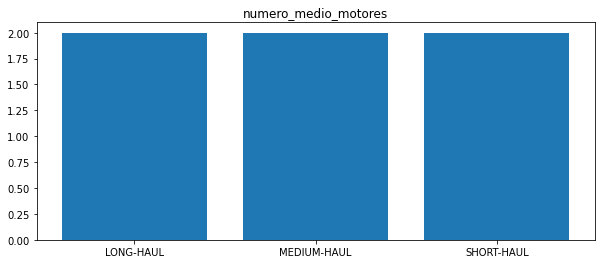

In [140]:
df_final.groupBy('fl_haul_duration').agg(F.round(F.avg(F.col('pl_engines')),2).alias('media_motores')).show(5)


## plot
df_plot4 = (df_final.groupBy('fl_haul_duration')
                    .agg(F.round(F.avg(F.col('pl_engines')),2)
                    .alias('media_motores')))

x = df_plot4.toPandas()['fl_haul_duration'].values.tolist()
y = df_plot4.toPandas()['media_motores'].values.tolist()


plt.figure(figsize=(10,4))
plt.bar(x,y)
plt.title('numero_medio_motores')
plt.show()

In [85]:
df_final.select(F.col('fl_haul_duration')).distinct().toPandas()

,fl_haul_duration
0,LONG-HAUL
1,MEDIUM-HAUL
2,SHORT-HAUL


### 27. Qual é a estação mais popular para voos?

In [138]:
(df_final.select(F.col('fl_dep_season'))
         .groupBy('fl_dep_season')
         .agg(F.count('fl_dep_season').alias('estacao_popular'))
         .orderBy('estacao_popular', ascending=False)
         .show(1)
)

+-------------+---------------+
|fl_dep_season|estacao_popular|
+-------------+---------------+
|        SUMER|           2918|
+-------------+---------------+
only showing top 1 row



### 28. Qual é a estação mais popular para voos em cada um dos destinos?

In [111]:
df_final.groupBy('fl_dep_season', 'fl_dest').count().sort('count', ascending = False).show(1)

+-------------+-------+-----+
|fl_dep_season|fl_dest|count|
+-------------+-------+-----+
|        SUMER|    SFO|  217|
+-------------+-------+-----+
only showing top 1 row



In [107]:
(
df_final.groupBy('fl_dep_season', 'fl_dest')
        .count().sort('count', ascending = False).show(1)
)

+-------------+-------+-----+
|fl_dep_season|fl_dest|count|
+-------------+-------+-----+
|        SUMER|    SFO|  217|
+-------------+-------+-----+
only showing top 1 row



In [110]:
(df_final.select(F.col('fl_dep_season'),F.col('fl_dest'))
         .groupBy('fl_dep_season','fl_dest')
         .agg(F.count('fl_dest').alias('modelo_dest'))
         .orderBy('modelo_dest', ascending=False)
         .show(1)
)

+-------------+-------+-----------+
|fl_dep_season|fl_dest|modelo_dest|
+-------------+-------+-----------+
|        SUMER|    SFO|        217|
+-------------+-------+-----------+
only showing top 1 row



### 29. Qual é a categoria de atrasos mais comum?

In [124]:
(
df_final.where(df_final.fl_dep_delay_category != 'ANTECIPATED')
        .groupBy('fl_dep_delay_category')
        .count().sort('count', ascending = False).show(1)
)

+---------------------+-----+
|fl_dep_delay_category|count|
+---------------------+-----+
|                MINOR| 3065|
+---------------------+-----+
only showing top 1 row



In [125]:
(df_final.select(F.col('fl_dep_delay_category'))
         .where(df_final.fl_dep_delay_category != 'ANTECIPATED')
         .groupBy('fl_dep_delay_category')
         .agg(F.count('fl_dep_delay_category').alias('atrasos_comum'))
         .orderBy('atrasos_comum', ascending=False)
         .show(1)
)

+---------------------+-------------+
|fl_dep_delay_category|atrasos_comum|
+---------------------+-------------+
|                MINOR|         3065|
+---------------------+-------------+
only showing top 1 row



### 30. Qual é a categoria de atrasos mais comum por rota?

In [128]:
(
df_final.where(df_final.fl_dep_delay_category != 'ANTECIPATED')
        .groupBy('fl_dep_delay_category', 'fl_origin','fl_dest')
        .count().sort('count', ascending = False).show(1)
)

+---------------------+---------+-------+-----+
|fl_dep_delay_category|fl_origin|fl_dest|count|
+---------------------+---------+-------+-----+
|                MINOR|      SEA|    SFO|  159|
+---------------------+---------+-------+-----+
only showing top 1 row

